In [313]:
import umap
import umap.plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.feature_selection import SelectKBest, f_classif
import hdbscan
import numpy as np

# Data preparation

In [140]:
sampled_genes = pd.read_csv("sampled_genes.csv")
sampled_stats = pd.read_csv("sampled_stats.csv")

In [167]:
#create four asthma groups
sampled_stats["asthma_group"] = None
for index, row in sampled_stats.iterrows():
    if row.asthma_age10 == "Yes" and row.asthma_age7 == "Yes":
        sampled_stats.loc[index, "asthma_group"] = 1
    if row.asthma_age10 == "No" and row.asthma_age7 == "No":
        sampled_stats.loc[index, "asthma_group"] = 2
    if row.asthma_age10 == "No" and row.asthma_age7 == "Yes":
        sampled_stats.loc[index, "asthma_group"] = 3
    if row.asthma_age10 == "Yes" and row.asthma_age7 == "No":
        sampled_stats.loc[index, "asthma_group"] = 4

sampled_stats

,StudyID,Sex,asthma_age10,asthma_age7,asthma_group
0,07-07-020-6,Male,Yes,Yes,1
1,07-02-092-3,Female,Yes,Yes,1
2,07-08-028-2,Male,Yes,Yes,1
3,07-08-106-4,Male,Yes,Yes,1
4,07-02-076-7,Male,Yes,Yes,1
...,...,...,...,...,...
115,07-08-125-4,Female,No,No,2
116,07-01-040-9,Male,No,No,2
117,07-01-108-1,Male,No,No,2
118,07-01-044-5,Male,No,No,2


In [408]:
gene_expr = sampled_genes.iloc[:,6:]
gene_expr = gene_expr.transpose()
gene_expr["StudyID"] = gene_expr.index
genes_combined = pd.merge(gene_expr, sampled_stats, on = "StudyID")
genes_combined

,0,1,2,3,4,5,6,7,8,9,...,15639,15640,15641,15642,15643,StudyID,Sex,asthma_age10,asthma_age7,asthma_group
0,-1.017234,4.165987,5.447652,8.306946,4.537354,6.580197,5.211584,7.321131,6.052439,5.118902,...,2.152691,4.139270,3.664590,5.802945,4.316666,07-08-095-0,Male,No,No,2
1,-0.111401,3.058524,5.354574,8.232895,4.253172,6.662068,5.701098,7.205107,5.790673,4.577898,...,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,07-08-120-8,Female,No,Yes,3
2,-2.065918,3.488671,5.511511,8.092691,4.200868,6.658596,4.899866,7.249231,6.260511,4.563438,...,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,07-08-122-0,Female,No,Yes,3
3,-2.264743,4.110296,5.342587,7.818736,3.757625,7.050406,5.169885,7.514976,5.920132,3.463177,...,-2.264743,-2.264743,-2.264743,-0.679781,-2.264743,07-08-123-1,Female,Yes,No,4
4,-0.535400,5.530689,5.993380,8.007632,4.254677,6.422670,5.667540,6.871160,5.155762,4.219488,...,3.660997,3.607558,3.305902,5.347243,4.146424,07-08-015-6,Male,No,Yes,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-2.393736,4.476629,5.073870,8.140567,4.206177,6.620285,4.900885,6.916877,6.344357,4.235621,...,-2.393736,-2.393736,-2.393736,-2.393736,-2.393736,07-08-160-0,Female,No,No,2
116,-2.645699,3.729341,6.132378,8.220807,4.320085,6.807572,5.075400,6.906970,6.184024,4.976353,...,2.846154,3.082222,4.648922,4.838117,4.514172,07-08-163-7,Male,No,No,2
117,1.046400,4.381385,6.219964,8.185952,3.419859,6.784185,5.252305,6.989981,6.241605,4.552753,...,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,07-08-085-2,Female,No,No,2
118,-2.576835,2.780717,5.311909,7.858836,4.388950,6.420345,5.811183,7.135692,6.356856,4.736048,...,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,07-08-082-3,Female,Yes,Yes,1


In [170]:
#find genes associated with asthma at age 10
f_scores, p_values = f_classif(genes_combined.iloc[:, 0:15644], genes_combined.asthma_age10)
gene_stats = pd.DataFrame({
    'Gene': genes_combined.columns[0:15644],
    "F_score": f_scores,
    "p-value": p_values})
gene_stats_sorted = gene_stats.sort_values(by = ["p-value"])
gene_stats_sorted

significant_genes = gene_stats_sorted[gene_stats_sorted["p-value"] < 0.01]
significant_gene_idx_10 = list(significant_genes.index)
selected_genes_10 = gene_expr.iloc[:, significant_gene_idx_10]
selected_genes_10

,13215,8932,6389,14859,2007,14342,12769,8136,705,85,...,9927,7512,9179,1747,13058,11196,4085,9010,12489,3198
07-08-095-0,6.871509,6.730958,6.761938,7.241724,0.205158,6.122317,0.857235,4.692424,-2.602197,7.018023,...,7.106887,-2.602197,7.089547,7.546280,7.099976,6.859283,4.056015,7.707279,6.539910,5.532229
07-08-120-8,6.802685,6.826414,5.865879,7.149754,-0.111401,6.586262,-2.433329,4.009615,-2.433329,7.119340,...,7.230229,0.736596,6.763888,7.660749,6.877284,5.731578,4.842796,8.501099,7.272304,4.726543
07-08-122-0,6.397606,7.101500,5.894084,7.590507,2.577938,6.453718,-0.480956,4.503937,-2.065918,6.397606,...,7.395561,-2.065918,7.226403,7.298216,7.174873,6.637985,2.326399,8.209042,6.891184,4.162900
07-08-123-1,5.838545,7.600990,5.357309,7.221086,-2.264743,6.820065,-2.264743,5.083985,-2.264743,6.293678,...,6.776916,-2.264743,6.131862,7.355477,7.045870,5.729610,2.689453,7.505095,6.239083,3.407682
07-08-015-6,5.792527,7.521689,5.896446,7.139381,-2.120362,6.562632,0.201566,4.508994,3.237190,6.399274,...,6.657715,-2.120362,6.351313,6.783520,7.129936,6.343162,3.305902,7.571381,5.918557,5.363453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07-08-160-0,6.603444,6.803481,5.589258,7.266260,1.693727,6.467351,1.306704,4.320510,-2.393736,7.051279,...,6.961616,-2.393736,6.620285,6.921414,7.116039,6.053348,3.946114,8.052314,6.217289,4.683080
07-08-163-7,6.293880,7.114189,5.425764,7.280597,0.524226,6.491292,-0.323771,4.365528,-2.645699,6.551518,...,6.516692,-1.060736,6.782661,6.678482,7.210727,6.362730,3.621088,7.301207,6.270181,4.040802
07-08-085-2,6.066749,7.112490,5.335162,7.424597,1.674432,6.561383,-2.413031,4.481787,-2.413031,6.650364,...,6.832521,-0.091103,6.538253,6.391100,7.340185,6.744316,3.695493,7.667786,6.496862,5.294328
07-08-082-3,6.585557,7.100885,5.116652,7.219205,-2.576835,6.673464,-0.991872,4.365680,-0.991872,6.774105,...,7.301216,-2.576835,7.186378,6.625289,6.769679,6.220827,4.023078,7.972950,6.327047,4.661570


In [171]:
#find genes associated with asthma at age 7
f_scores, p_values = f_classif(genes_combined.iloc[:, 0:15644], genes_combined.asthma_age7)
gene_stats = pd.DataFrame({
    'Gene': genes_combined.columns[0:15644],
    "F_score": f_scores,
    "p-value": p_values})
gene_stats_sorted = gene_stats.sort_values(by = ["p-value"])
gene_stats_sorted

significant_genes = gene_stats_sorted[gene_stats_sorted["p-value"] < 0.01]
significant_gene_idx_7 = list(significant_genes.index)
selected_genes_7 = gene_expr.iloc[:, significant_gene_idx_7]
selected_genes_7

,13215,8932,6389,14859,2007,14342,12769,8136,705,85,...,9927,7512,9179,1747,13058,11196,4085,9010,12489,3198
07-08-095-0,6.871509,6.730958,6.761938,7.241724,0.205158,6.122317,0.857235,4.692424,-2.602197,7.018023,...,7.106887,-2.602197,7.089547,7.546280,7.099976,6.859283,4.056015,7.707279,6.539910,5.532229
07-08-120-8,6.802685,6.826414,5.865879,7.149754,-0.111401,6.586262,-2.433329,4.009615,-2.433329,7.119340,...,7.230229,0.736596,6.763888,7.660749,6.877284,5.731578,4.842796,8.501099,7.272304,4.726543
07-08-122-0,6.397606,7.101500,5.894084,7.590507,2.577938,6.453718,-0.480956,4.503937,-2.065918,6.397606,...,7.395561,-2.065918,7.226403,7.298216,7.174873,6.637985,2.326399,8.209042,6.891184,4.162900
07-08-123-1,5.838545,7.600990,5.357309,7.221086,-2.264743,6.820065,-2.264743,5.083985,-2.264743,6.293678,...,6.776916,-2.264743,6.131862,7.355477,7.045870,5.729610,2.689453,7.505095,6.239083,3.407682
07-08-015-6,5.792527,7.521689,5.896446,7.139381,-2.120362,6.562632,0.201566,4.508994,3.237190,6.399274,...,6.657715,-2.120362,6.351313,6.783520,7.129936,6.343162,3.305902,7.571381,5.918557,5.363453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07-08-160-0,6.603444,6.803481,5.589258,7.266260,1.693727,6.467351,1.306704,4.320510,-2.393736,7.051279,...,6.961616,-2.393736,6.620285,6.921414,7.116039,6.053348,3.946114,8.052314,6.217289,4.683080
07-08-163-7,6.293880,7.114189,5.425764,7.280597,0.524226,6.491292,-0.323771,4.365528,-2.645699,6.551518,...,6.516692,-1.060736,6.782661,6.678482,7.210727,6.362730,3.621088,7.301207,6.270181,4.040802
07-08-085-2,6.066749,7.112490,5.335162,7.424597,1.674432,6.561383,-2.413031,4.481787,-2.413031,6.650364,...,6.832521,-0.091103,6.538253,6.391100,7.340185,6.744316,3.695493,7.667786,6.496862,5.294328
07-08-082-3,6.585557,7.100885,5.116652,7.219205,-2.576835,6.673464,-0.991872,4.365680,-0.991872,6.774105,...,7.301216,-2.576835,7.186378,6.625289,6.769679,6.220827,4.023078,7.972950,6.327047,4.661570


In [181]:
#combine gene lists for all asthma associated genes
gene_names_10 = sampled_genes.iloc[significant_gene_idx_10, :]
gene_names_7 = sampled_genes.iloc[significant_gene_idx_7, :]
gene_names = pd.concat([gene_names_10, gene_names_7], axis = 0).drop_duplicates()
gene_names.to_csv("significant_genes_asthma.csv", index = False)
selected_gene_expr = gene_names.iloc[:, 6:].transpose()

In [420]:
#import sex associated genes, from Roger Fan's code
sex_genes = pd.read_csv("gene.csv")
sex_genes

,Unnamed: 0,15638,15635,15642,15634,15643,15636,15641,15639,15637,...,12637,1420,10261,1889,13394,3203,2989,8140,2236,4785
0,0,6.721984,6.433977,5.802945,6.585155,4.316666,5.425709,3.664590,2.152691,4.929185,...,5.869478,3.664590,4.929185,6.555150,5.542461,7.672764,-0.280269,4.409030,1.921365,6.614549
1,1,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,...,5.659428,2.776125,5.128914,6.390038,4.105830,8.027127,-2.433329,4.726543,1.654134,6.005463
2,2,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,...,2.688969,4.876596,5.917075,5.810599,4.702266,7.717080,-0.480956,5.093953,3.219484,6.372874
3,3,-0.679781,-2.264743,-0.679781,-0.679781,-2.264743,-0.679781,-2.264743,-2.264743,-2.264743,...,4.934929,3.516617,5.327714,6.308904,5.879915,7.673366,-2.264743,5.083985,0.542612,6.486801
4,4,7.125190,6.187977,5.347243,7.086652,4.146424,5.862631,3.305902,3.660997,3.371491,...,6.197050,1.339069,5.314266,6.548523,4.449493,7.539634,-0.535400,4.977670,0.686993,6.644509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,-2.393736,-2.393736,-2.393736,-0.071807,-2.393736,-2.393736,-2.393736,-2.393736,-2.393736,...,4.766136,-0.808773,5.730386,6.783684,5.458013,7.673699,0.413619,4.320510,0.413619,5.677727
116,116,6.585522,6.001760,4.838117,7.247603,4.514172,6.023186,4.648922,2.846154,4.095768,...,5.348655,0.161656,5.635072,6.551518,4.122485,7.677356,-2.645699,4.199791,-0.323771,6.390475
117,117,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,...,5.133863,1.979286,5.294328,6.692877,5.535336,7.427747,2.944521,4.381385,1.287408,6.168169
118,118,-0.991872,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,...,6.048874,4.365680,6.099123,6.644753,6.475734,7.903956,-2.576835,4.622838,2.067022,5.894841


In [354]:
sample_ids = pd.DataFrame(selected_gene_expr.index)
sample_ids = sample_ids.rename(columns = {0: "StudyID"})
df = pd.merge(sample_ids, sampled_stats, on = "StudyID")
df

,StudyID,Sex,asthma_age10,asthma_age7,asthma_group
0,07-08-095-0,Male,No,No,2
1,07-08-120-8,Female,No,Yes,3
2,07-08-122-0,Female,No,Yes,3
3,07-08-123-1,Female,Yes,No,4
4,07-08-015-6,Male,No,Yes,3
...,...,...,...,...,...
115,07-08-160-0,Female,No,No,2
116,07-08-163-7,Male,No,No,2
117,07-08-085-2,Female,No,No,2
118,07-08-082-3,Female,Yes,Yes,1


# UMAP

In [337]:
#perform UMAP with asthma genes
asthma_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.0).fit_transform(selected_gene_expr)

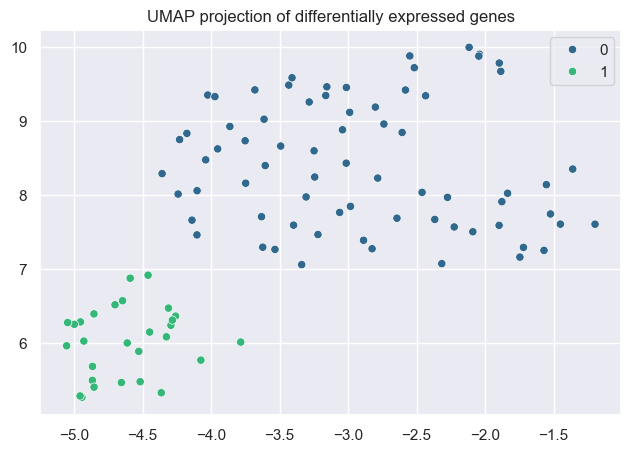

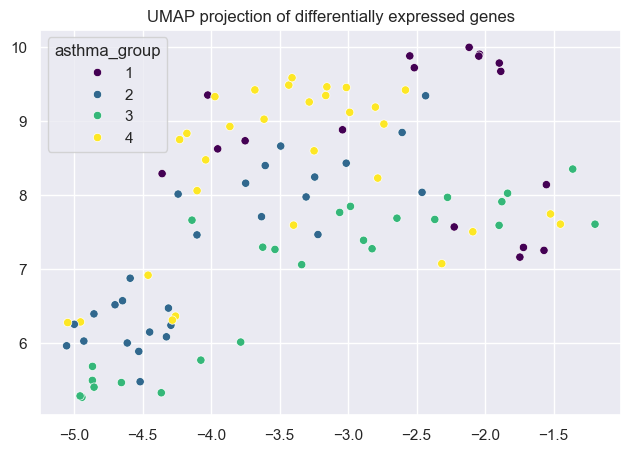

In [355]:
sns.set_theme(rc={'figure.figsize':(7.5,5)})


labels = hdbscan.HDBSCAN(
    min_cluster_size=10,
).fit_predict(asthma_embedding)

clustered = (labels >= 0)

sns.scatterplot(x = asthma_embedding[clustered, 0], y = asthma_embedding[clustered, 1], hue=labels[clustered], palette = "viridis")
plt.title("UMAP projection of differentially expressed genes")
plt.show()

sns.scatterplot(x = asthma_embedding[clustered, 0], y = asthma_embedding[clustered, 1], hue=df.asthma_group[clustered], palette = "viridis")
plt.title("UMAP projection of differentially expressed genes")
plt.show()

In [236]:
#perform UMAP with sex genes
sex_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.0).fit_transform(sex_genes)

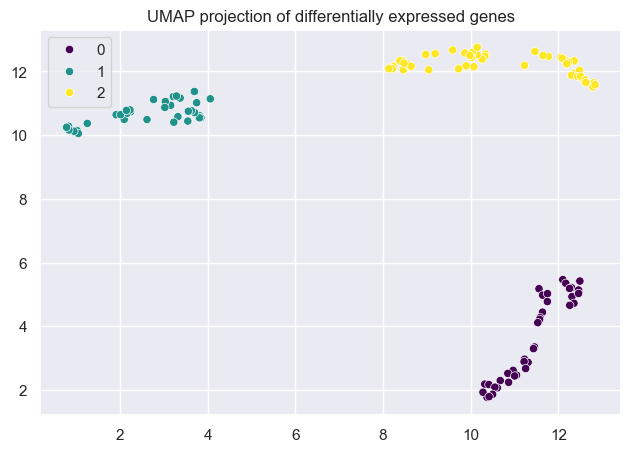

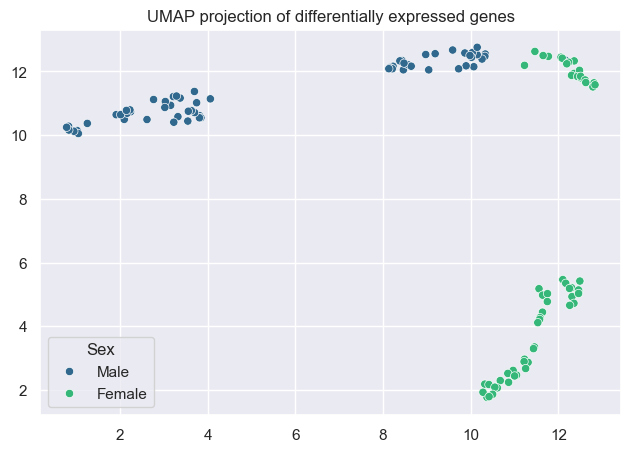

In [356]:
labels = hdbscan.HDBSCAN(
    min_cluster_size=10,
).fit_predict(sex_embedding)

clustered = (labels >= 0)


sns.scatterplot(x = sex_embedding[clustered, 0], y = sex_embedding[clustered, 1], hue=labels[clustered], palette = "viridis")
plt.title("UMAP projection of differentially expressed genes")
plt.show()

sns.scatterplot(x = sex_embedding[clustered, 0], y = sex_embedding[clustered, 1], hue=df.Sex[clustered], palette = "viridis")
plt.title("UMAP projection of differentially expressed genes")
plt.show()

# Nearest neighbors - asthma

In [360]:
array = np.array(selected_gene_expr)
distances_mat = np.empty((selected_genes.shape[0], selected_genes.shape[0]))
for idx, row in enumerate(array):
    dist = np.apply_along_axis(lambda x: np.linalg.norm(x - row), 1, array)
    distances_mat[idx, :] = dist

names = selected_genes.index
distances_df = pd.DataFrame(distances_mat)
distances_df.index = names
distances_df.columns = names
distances_df

,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,07-08-015-6,07-08-017-3,07-08-026-9,07-08-128-3,07-08-117-4,07-01-100-6,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
07-08-095-0,0.000000,30.364060,31.367010,32.730706,32.015080,30.553371,24.877707,27.945088,30.465476,28.665860,...,30.643132,31.463315,31.153386,23.824924,26.707599,23.357179,25.334772,24.750146,27.192550,26.530041
07-08-120-8,30.364060,0.000000,27.783434,35.353542,35.119640,33.204047,29.772812,32.691353,38.154985,33.933930,...,33.410548,34.833137,36.715198,33.040076,28.029098,31.793114,32.915029,31.263947,30.156085,31.520459
07-08-122-0,31.367010,27.783434,0.000000,36.561028,33.081194,34.106803,31.072870,32.595188,38.702907,33.369665,...,33.479097,35.514245,39.805593,33.456617,25.912462,29.905481,34.556847,31.703929,29.434456,32.149921
07-08-123-1,32.730706,35.353542,36.561028,0.000000,29.579638,24.517369,26.525830,25.805034,26.198693,31.799581,...,28.579458,39.143443,30.398760,32.968658,38.713368,32.275839,32.090531,31.206628,30.107861,30.954519
07-08-015-6,32.015080,35.119640,33.081194,29.579638,0.000000,28.152701,29.296694,25.337646,31.624977,27.539223,...,26.344895,38.342346,32.726771,31.770500,34.514359,30.909062,30.937187,31.855600,28.912334,30.770557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07-08-160-0,23.357179,31.793114,29.905481,32.275839,30.909062,31.568110,25.053399,25.126487,27.905187,27.676294,...,29.798544,27.729347,29.680201,23.391983,27.404198,0.000000,24.396759,21.740395,27.455826,21.825868
07-08-163-7,25.334772,32.915029,34.556847,32.090531,30.937187,31.563576,26.845025,28.396001,28.366493,28.118432,...,30.223170,31.787088,27.916121,20.991145,30.813063,24.396759,0.000000,22.190806,29.726511,25.173590
07-08-085-2,24.750146,31.263947,31.703929,31.206628,31.855600,30.807195,23.782572,27.195435,25.564999,27.781477,...,29.666604,30.267060,25.784105,23.135069,27.600619,21.740395,22.190806,0.000000,27.191236,24.323616
07-08-082-3,27.192550,30.156085,29.434456,30.107861,28.912334,27.179007,26.471500,27.568184,33.910834,30.005109,...,30.316215,34.618517,33.694152,30.231264,29.237482,27.455826,29.726511,27.191236,0.000000,29.842392


In [327]:
top_dists = pd.DataFrame([])
top_neighbors = pd.DataFrame([])

for idx, row in distances_df.iterrows():
    sorted_row = row.sort_values()
    top = sorted_row[1:11]
    top_dists[idx] = top.values
    top_neighbors[idx] = top.index


top_neighbors.to_csv("top_neighbors_asthma_genes.csv")
top_neighbors

C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\200317168.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  top_dists[idx] = top.values
C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\200317168.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  top_neighbors[idx] = top.index
C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\200317168.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,07-08-015-6,07-08-017-3,07-08-026-9,07-08-128-3,07-08-117-4,07-01-100-6,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
0,07-08-160-0,07-08-081-0,07-08-081-0,07-01-013-3,07-01-103-4,07-02-109-0,07-08-046-1,07-02-046-3,07-01-013-3,07-08-103-8,...,07-01-001-1,07-08-081-0,07-07-060-3,07-02-002-5,07-08-081-0,07-08-085-2,07-08-060-4,07-01-034-1,07-07-029-9,07-08-160-0
1,07-07-029-9,07-08-096-6,07-08-151-8,07-08-117-4,07-02-095-2,07-02-046-3,07-08-106-4,07-08-065-8,07-02-134-9,07-01-068-3,...,07-08-091-3,07-08-160-0,07-07-010-1,07-08-142-7,07-01-044-5,07-01-040-9,07-08-085-2,07-08-021-1,07-08-160-0,07-02-022-1
2,07-02-027-8,07-02-057-4,07-08-160-0,07-02-118-5,07-02-046-3,07-08-031-4,07-02-046-3,07-02-118-5,07-02-091-0,07-01-039-4,...,07-08-051-7,07-02-022-1,07-02-023-2,07-02-045-9,07-08-125-4,07-08-021-1,07-02-045-9,07-01-044-5,07-08-021-1,07-08-113-5
3,07-08-021-1,07-08-021-1,07-08-120-8,07-08-017-3,07-02-085-4,07-08-065-8,07-02-134-9,07-08-113-5,07-02-023-2,07-01-103-4,...,07-01-013-3,07-01-044-5,07-01-083-8,07-01-040-9,07-08-122-0,07-08-095-0,07-01-038-7,07-01-040-9,07-08-156-0,07-08-154-1
4,07-01-040-9,07-08-122-0,07-08-034-6,07-02-134-9,07-07-029-9,07-01-083-8,07-02-027-8,07-02-038-2,07-02-095-2,07-07-036-6,...,07-02-125-1,07-02-057-4,07-02-085-4,07-01-166-9,07-08-095-0,07-08-103-8,07-08-154-1,07-02-045-9,07-01-039-4,07-08-112-6
5,07-02-022-1,07-08-151-8,07-01-044-5,07-02-109-0,07-07-023-4,07-02-085-4,07-08-065-8,07-01-013-3,07-01-028-5,07-02-046-3,...,07-02-046-3,07-01-151-4,07-02-048-5,07-07-029-9,07-02-093-4,07-01-044-5,07-01-040-9,07-08-156-0,07-02-046-3,07-01-100-6
6,07-01-044-5,07-01-151-4,07-02-057-4,07-01-083-8,07-08-065-8,07-08-106-4,07-01-028-5,07-01-001-1,07-02-048-5,07-08-142-7,...,07-02-019-1,07-08-096-6,07-02-034-8,07-08-085-2,07-08-160-0,07-07-029-9,07-08-113-5,07-08-160-0,07-08-013-9,07-08-060-4
7,07-08-034-6,07-02-002-5,07-08-103-8,07-01-061-2,07-07-019-3,07-08-123-1,07-08-117-4,07-08-103-8,07-01-083-8,07-01-038-7,...,07-08-113-5,07-08-103-8,07-07-018-6,07-08-113-5,07-08-120-8,07-08-034-6,07-08-021-1,07-08-060-4,07-02-022-1,07-08-128-3
8,07-08-060-4,07-02-022-1,07-08-021-1,07-07-020-6,07-02-027-8,07-08-051-7,07-01-034-1,07-01-061-2,07-08-065-8,07-08-113-5,...,07-07-029-9,07-08-095-0,07-02-039-5,07-08-163-7,07-08-034-6,07-08-154-1,07-08-156-0,07-07-029-9,07-08-103-8,07-01-166-9
9,07-08-142-7,07-01-044-5,07-08-156-0,07-02-034-8,07-02-134-9,07-07-005-8,07-07-064-2,07-08-068-9,07-02-009-4,07-07-029-9,...,07-02-118-5,07-01-040-9,07-08-065-8,07-01-034-1,07-02-057-4,07-08-081-0,07-01-034-1,07-08-113-5,07-08-085-2,07-01-034-1


In [366]:
UMAP = pd.DataFrame(asthma_embedding)
UMAP.index = df.StudyID
UMAP = UMAP.reset_index()
UMAP

,StudyID,0,1
0,07-08-095-0,-4.527708,5.887131
1,07-08-120-8,-4.718212,5.199424
2,07-08-122-0,-4.942693,5.267606
3,07-08-123-1,-1.522771,7.741402
4,07-08-015-6,-1.360102,8.347207
...,...,...,...
115,07-08-160-0,-4.928798,6.026468
116,07-08-163-7,-4.646411,6.570595
117,07-08-085-2,-4.701259,6.516078
118,07-08-082-3,-1.240565,7.157032


In [376]:
array = np.array(UMAP.iloc[ :, 1:3])
UMAP_distances_mat = np.empty((UMAP.shape[0], UMAP.shape[0]))
for idx, row in enumerate(array):
    dist = np.apply_along_axis(lambda x: np.linalg.norm(x - row), 1, array)
    UMAP_distances_mat[idx, :] = dist

names = UMAP.StudyID
UMAP_distances_df = pd.DataFrame(UMAP_distances_mat)
UMAP_distances_df.index = names
UMAP_distances_df.columns = names
UMAP_distances_df

StudyID,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,07-08-015-6,07-08-017-3,07-08-026-9,07-08-128-3,07-08-117-4,07-01-100-6,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
StudyID,,,,,,,,,,,,,,,,,,,,,
07-08-095-0,0.000000,0.713605,0.745670,3.531001,4.010699,3.523896,3.138822,3.729835,2.956597,2.017638,...,4.433303,0.532239,4.034766,0.622980,0.738200,0.424603,0.693696,0.652453,3.523912,0.648625
07-08-120-8,0.713605,0.000000,0.234607,4.083197,4.602765,4.057189,3.655251,4.318388,3.649714,2.550261,...,5.028065,0.834047,4.725476,1.335395,0.253332,0.853433,1.373049,1.316763,3.990771,1.125582
07-08-122-0,0.745670,0.234607,0.000000,4.220845,4.724288,4.201802,3.804859,4.441196,3.701445,2.690591,...,5.148735,0.703982,4.779809,1.359258,0.022915,0.758989,1.336250,1.271603,4.156402,1.013716
07-08-123-1,3.531001,4.083197,4.220845,0.000000,0.627265,0.155521,0.492494,0.396377,1.640737,1.532938,...,1.017879,3.954433,1.836754,3.064130,4.221085,3.813400,3.335853,3.406494,0.648945,3.816651
07-08-015-6,4.010699,4.602765,4.724288,0.627265,0.000000,0.748823,1.116681,0.285280,1.655388,2.071618,...,0.425468,4.397180,1.459918,3.496916,4.722603,4.256927,3.735797,3.810034,1.196163,4.228754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07-08-160-0,0.424603,0.853433,0.758989,3.813400,4.256927,3.819478,3.448756,3.981413,3.070614,2.334554,...,4.674224,0.141034,4.144632,0.761063,0.740910,0.000000,0.613039,0.539901,3.857621,0.276016
07-08-163-7,0.693696,1.373049,1.336250,3.335853,3.735797,3.359027,3.013685,3.467601,2.472018,1.937329,...,4.145634,0.732253,3.541612,0.349536,1.321371,0.613039,0.000000,0.077332,3.455965,0.497174
07-08-085-2,0.652453,1.316763,1.271603,3.406494,3.810034,3.428163,3.080220,3.541238,2.549182,1.998460,...,4.220458,0.656594,3.618456,0.392546,1.256167,0.539901,0.077332,0.000000,3.519548,0.420842


In [377]:
top_dists_UMAP = pd.DataFrame([])
top_neighbors_UMAP = pd.DataFrame([])

for idx, row in UMAP_distances_df.iterrows():
    sorted_row = row.sort_values()
    top = sorted_row[1:11]
    top_dists_UMAP[idx] = top.values
    top_neighbors_UMAP[idx] = top.index

C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\175796795.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  top_dists_UMAP[idx] = top.values
C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\175796795.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  top_neighbors_UMAP[idx] = top.index
C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\175796795.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

In [378]:
top_neighbors_UMAP

,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,07-08-015-6,07-08-017-3,07-08-026-9,07-08-128-3,07-08-117-4,07-01-100-6,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
0,07-01-044-5,07-08-122-0,07-08-151-8,07-08-017-3,07-02-019-1,07-08-123-1,07-08-046-1,07-08-015-6,07-02-103-5,07-07-036-6,...,07-07-019-3,07-08-160-0,07-02-018-9,07-08-156-0,07-08-122-0,07-02-139-6,07-08-085-2,07-08-163-7,07-07-016-4,07-02-022-1
1,07-02-002-5,07-02-057-4,07-02-057-4,07-08-051-7,07-08-128-3,07-08-051-7,07-08-106-4,07-07-064-2,07-02-091-0,07-08-013-9,...,07-02-019-1,07-02-022-1,07-02-039-5,07-08-154-1,07-02-057-4,07-02-022-1,07-01-151-4,07-01-151-4,07-08-106-4,07-01-006-9
2,07-08-021-1,07-08-151-8,07-08-120-8,07-02-038-2,07-02-106-1,07-08-106-4,07-02-046-3,07-08-123-1,07-08-065-8,07-07-023-4,...,07-02-106-1,07-08-103-8,07-01-083-8,07-01-040-9,07-08-081-0,07-01-006-9,07-01-074-3,07-01-006-9,07-08-051-7,07-01-151-4
3,07-08-034-6,07-02-093-4,07-08-081-0,07-08-128-3,07-08-007-1,07-08-026-9,07-08-017-3,07-02-038-2,07-02-092-3,07-07-018-6,...,07-08-091-3,07-08-034-6,07-02-009-4,07-08-163-7,07-08-120-8,07-08-103-8,07-08-060-4,07-01-074-3,07-08-017-3,07-08-160-0
4,07-08-125-4,07-08-081-0,07-02-093-4,07-02-046-3,07-07-019-3,07-02-046-3,07-01-060-8,07-08-007-1,07-02-125-1,07-08-014-1,...,07-08-015-6,07-01-006-9,07-02-048-5,07-02-002-5,07-02-093-4,07-01-044-5,07-07-012-9,07-08-060-4,07-08-026-9,07-02-139-6
5,07-01-040-9,07-08-125-4,07-08-034-6,07-07-064-2,07-02-141-7,07-07-016-4,07-08-123-1,07-02-019-1,07-01-002-4,07-01-103-4,...,07-08-007-1,07-01-044-5,07-07-111-8,07-08-021-1,07-08-034-6,07-08-034-6,07-01-006-9,07-02-022-1,07-08-046-1,07-08-085-2
6,07-08-160-0,07-08-096-6,07-08-125-4,07-08-026-9,07-07-064-2,07-08-082-3,07-08-082-3,07-08-017-3,07-02-048-5,07-02-095-2,...,07-08-128-3,07-01-151-4,07-02-076-7,07-08-085-2,07-08-125-4,07-01-151-4,07-08-156-0,07-08-103-8,07-08-123-1,07-08-163-7
7,07-02-093-4,07-08-034-6,07-08-096-6,07-08-106-4,07-08-123-1,07-02-038-2,07-07-016-4,07-02-106-1,07-02-017-0,07-07-005-8,...,07-08-049-0,07-08-081-0,07-01-013-3,07-07-012-9,07-08-096-6,07-08-095-0,07-08-154-1,07-02-002-5,07-02-046-3,07-01-044-5
8,07-07-029-9,07-08-095-0,07-02-139-6,07-01-060-8,07-08-091-3,07-08-046-1,07-07-005-8,07-08-051-7,07-01-108-1,07-01-130-1,...,07-02-109-0,07-08-095-0,07-01-001-1,07-01-074-3,07-02-139-6,07-02-002-5,07-02-002-5,07-07-012-9,07-01-060-8,07-02-002-5
9,07-08-154-1,07-01-044-5,07-08-095-0,07-08-046-1,07-02-038-2,07-08-128-3,07-08-051-7,07-02-046-3,07-02-009-4,07-02-023-2,...,07-07-064-2,07-02-057-4,07-07-093-1,07-01-151-4,07-08-095-0,07-08-081-0,07-02-022-1,07-08-154-1,07-02-038-2,07-08-034-6


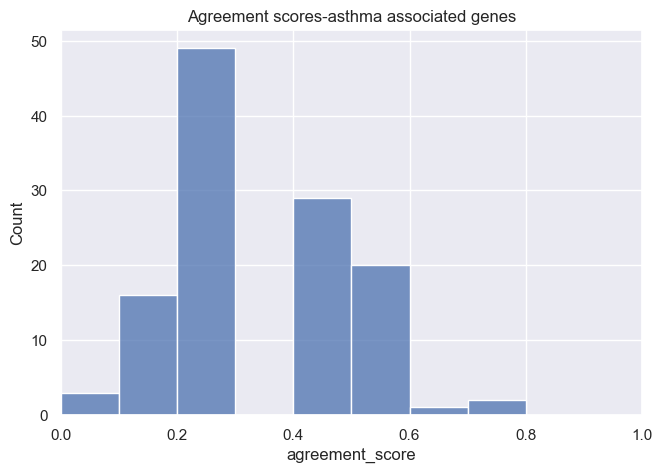

In [431]:
score = []

for idx in range(120):
    raw_data = set(top_neighbors.iloc[:, idx])
    UMAP_data = set(top_neighbors_UMAP.iloc[:, idx])
    score.append(len(raw_data.intersection(UMAP_data))/10)

score = pd.DataFrame(score)
score.index = top_neighbors.columns
score.columns = ["agreement_score"]

# print(np.mean(score.agreement_score))
# print(np.std(score.agreement_score))
sns.histplot(score.agreement_score, binwidth = 0.1)
plt.title("Agreement scores-asthma associated genes")
plt.xlim((0,1))
plt.show()

# Nearest neighbors - Sex

In [421]:
array = np.array(sex_genes)
distances_mat = np.empty((sex_genes.shape[0], sex_genes.shape[0]))
for idx, row in enumerate(array):
    dist = np.apply_along_axis(lambda x: np.linalg.norm(x - row), 1, array)
    distances_mat[idx, :] = dist

names = selected_genes.index
sex_distances_df = pd.DataFrame(distances_mat)
sex_distances_df.index = names
sex_distances_df.columns = names
sex_distances_df

sex_top_dists = pd.DataFrame([])
sex_top_neighbors = pd.DataFrame([])

for idx, row in distances_df.iterrows():
    sorted_row = row.sort_values()
    top = sorted_row[1:11]
    sex_top_dists[idx] = top.values
    sex_top_neighbors[idx] = top.index


sex_top_neighbors.to_csv("top_neighbors_sex_genes.csv")
sex_top_neighbors

C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\3796900059.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sex_top_dists[idx] = top.values
C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\3796900059.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sex_top_neighbors[idx] = top.index
C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\3796900059.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,07-08-015-6,07-08-017-3,07-08-026-9,07-08-128-3,07-08-117-4,07-01-100-6,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
0,07-01-040-9,07-08-081-0,07-08-151-8,07-08-017-3,07-08-128-3,07-02-046-3,07-08-106-4,07-02-038-2,07-02-091-0,07-07-036-6,...,07-08-091-3,07-08-160-0,07-02-048-5,07-01-040-9,07-08-081-0,07-01-040-9,07-08-060-4,07-01-040-9,07-07-016-4,07-08-160-0
1,07-08-160-0,07-08-096-6,07-08-081-0,07-02-034-8,07-07-019-3,07-08-051-7,07-08-046-1,07-08-091-3,07-08-065-8,07-02-134-9,...,07-07-019-3,07-08-081-0,07-02-027-8,07-08-163-7,07-08-034-6,07-08-085-2,07-01-040-9,07-01-034-1,07-02-046-3,07-02-022-1
2,07-08-034-6,07-08-122-0,07-08-120-8,07-02-046-3,07-02-046-3,07-08-106-4,07-02-046-3,07-02-046-3,07-01-013-3,07-08-026-9,...,07-02-019-1,07-01-151-4,07-01-083-8,07-08-113-5,07-01-044-5,07-08-103-8,07-08-113-5,07-08-021-1,07-08-051-7,07-01-105-2
3,07-08-021-1,07-08-151-8,07-02-057-4,07-01-013-3,07-02-134-9,07-08-123-1,07-02-134-9,07-02-034-8,07-02-048-5,07-02-046-3,...,07-08-051-7,07-02-022-1,07-02-034-8,07-02-002-5,07-08-122-0,07-02-022-1,07-08-085-2,07-08-160-0,07-08-106-4,07-08-154-1
4,07-08-060-4,07-08-021-1,07-08-034-6,07-02-134-9,07-02-141-7,07-02-109-0,07-08-065-8,07-02-048-5,07-02-096-8,07-01-039-4,...,07-02-046-3,07-08-103-8,07-02-085-4,07-01-074-3,07-02-057-4,07-08-021-1,07-02-022-1,07-08-113-5,07-02-022-1,07-01-074-3
5,07-02-022-1,07-01-166-9,07-08-142-7,07-02-118-5,07-07-064-2,07-08-026-9,07-02-027-8,07-02-134-9,07-02-134-9,07-08-113-5,...,07-02-106-1,07-01-040-9,07-07-060-3,07-02-045-9,07-08-095-0,07-01-044-5,07-02-122-2,07-07-029-9,07-08-034-6,07-02-085-4
6,07-02-027-8,07-08-142-7,07-07-016-4,07-07-020-6,07-08-049-0,07-08-065-8,07-01-040-9,07-08-026-9,07-01-083-8,07-01-103-4,...,07-08-142-7,07-08-125-4,07-02-023-2,07-02-126-7,07-08-096-6,07-08-154-1,07-01-074-3,07-08-163-7,07-08-026-9,07-08-112-6
7,07-01-074-3,07-02-057-4,07-08-082-3,07-08-128-3,07-02-019-1,07-08-068-9,07-02-017-0,07-02-118-5,07-01-061-2,07-08-060-4,...,07-08-028-2,07-08-060-4,07-02-039-5,07-01-039-4,07-08-160-0,07-08-081-0,07-02-085-4,07-01-044-5,07-08-013-9,07-01-040-9
8,07-07-029-9,07-02-022-1,07-08-156-0,07-08-068-9,07-07-029-9,07-02-134-9,07-02-034-8,07-08-065-8,07-02-017-0,07-01-068-3,...,07-02-134-9,07-01-074-3,07-08-065-8,07-08-085-2,07-01-166-9,07-08-113-5,07-02-023-2,07-02-085-4,07-07-029-9,07-01-038-7
9,07-08-081-0,07-08-034-6,07-08-096-6,07-02-038-2,07-08-051-7,07-02-034-8,07-01-034-1,07-08-068-9,07-02-009-4,07-01-040-9,...,07-07-036-6,07-01-044-5,07-02-125-1,07-08-154-1,07-08-085-2,07-01-074-3,07-08-068-9,07-07-012-9,07-08-142-7,07-02-118-5


In [422]:
sex_UMAP = pd.DataFrame(sex_embedding)
sex_UMAP.index = df.StudyID
sex_UMAP = sex_UMAP.reset_index()
array = np.array(sex_UMAP.iloc[ :, 1:3])
sex_UMAP_distances_mat = np.empty((sex_UMAP.shape[0], sex_UMAP.shape[0]))
for idx, row in enumerate(array):
    dist = np.apply_along_axis(lambda x: np.linalg.norm(x - row), 1, array)
    sex_UMAP_distances_mat[idx, :] = dist

names = sex_UMAP.StudyID
sex_UMAP_distances_df = pd.DataFrame(sex_UMAP_distances_mat)
sex_UMAP_distances_df.index = names
sex_UMAP_distances_df.columns = names

sex_top_dists_UMAP = pd.DataFrame([])
sex_top_neighbors_UMAP = pd.DataFrame([])

for idx, row in sex_UMAP_distances_df.iterrows():
    sorted_row = row.sort_values()
    top = sorted_row[1:11]
    sex_top_dists_UMAP[idx] = top.values
    sex_top_neighbors_UMAP[idx] = top.index

C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\3270559998.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sex_top_dists_UMAP[idx] = top.values
C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\3270559998.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sex_top_neighbors_UMAP[idx] = top.index
C:\Users\mncgo\AppData\Local\Temp\ipykernel_25524\3270559998.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [423]:
sex_top_neighbors_UMAP

,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,07-08-015-6,07-08-017-3,07-08-026-9,07-08-128-3,07-08-117-4,07-01-100-6,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
0,07-01-124-3,07-01-100-6,07-08-017-3,07-08-017-3,07-08-128-3,07-08-122-0,07-01-083-8,07-08-015-6,07-08-128-3,07-08-120-8,...,07-07-019-3,07-01-061-2,07-07-029-9,07-08-103-8,07-08-082-3,07-08-082-3,07-08-103-8,07-08-160-0,07-08-160-0,07-08-060-4
1,07-01-103-4,07-08-026-9,07-08-120-8,07-08-122-0,07-08-117-4,07-08-123-1,07-01-100-6,07-08-117-4,07-08-015-6,07-08-026-9,...,07-02-048-5,07-08-163-7,07-01-074-3,07-08-163-7,07-08-160-0,07-08-151-8,07-08-060-4,07-08-082-3,07-08-151-8,07-08-163-7
2,07-08-117-4,07-01-083-8,07-01-100-6,07-07-064-2,07-01-105-2,07-08-120-8,07-08-125-4,07-01-105-2,07-01-105-2,07-01-083-8,...,07-02-019-1,07-01-166-9,07-08-151-8,07-02-139-6,07-02-147-2,07-08-085-2,07-02-139-6,07-08-151-8,07-08-085-2,07-02-139-6
3,07-08-156-0,07-08-125-4,07-08-123-1,07-08-120-8,07-08-142-7,07-01-100-6,07-08-120-8,07-01-103-4,07-01-103-4,07-08-125-4,...,07-07-036-6,07-08-060-4,07-07-023-4,07-01-061-2,07-08-085-2,07-02-147-2,07-01-061-2,07-02-057-4,07-02-147-2,07-01-061-2
4,07-08-137-5,07-08-122-0,07-08-026-9,07-01-100-6,07-01-108-1,07-07-064-2,07-01-068-3,07-01-108-1,07-08-137-5,07-01-068-3,...,07-02-046-3,07-08-103-8,07-02-057-4,07-01-166-9,07-07-029-9,07-07-029-9,07-01-166-9,07-01-074-3,07-07-029-9,07-01-166-9
5,07-01-105-2,07-01-068-3,07-08-125-4,07-08-026-9,07-01-103-4,07-08-026-9,07-08-122-0,07-08-142-7,07-01-108-1,07-08-122-0,...,07-02-038-2,07-01-044-5,07-08-085-2,07-01-044-5,07-01-074-3,07-01-074-3,07-01-044-5,07-02-147-2,07-01-074-3,07-01-044-5
6,07-08-128-3,07-08-017-3,07-01-083-8,07-08-125-4,07-08-137-5,07-08-125-4,07-08-096-6,07-08-137-5,07-08-095-0,07-08-017-3,...,07-08-150-2,07-02-046-3,07-08-082-3,07-02-046-3,07-02-057-4,07-02-057-4,07-02-046-3,07-07-029-9,07-02-057-4,07-02-046-3
7,07-01-108-1,07-08-112-6,07-01-068-3,07-01-083-8,07-08-144-3,07-01-083-8,07-08-112-6,07-08-095-0,07-08-142-7,07-08-096-6,...,07-01-060-8,07-07-036-6,07-02-045-9,07-07-036-6,07-07-023-4,07-07-023-4,07-07-036-6,07-07-023-4,07-07-023-4,07-07-036-6
8,07-08-144-3,07-08-096-6,07-07-064-2,07-01-068-3,07-08-095-0,07-01-068-3,07-07-060-3,07-08-144-3,07-01-124-3,07-08-112-6,...,07-01-028-5,07-02-038-2,07-08-160-0,07-02-038-2,07-02-045-9,07-02-045-9,07-02-038-2,07-02-045-9,07-02-045-9,07-02-038-2
9,07-08-015-6,07-07-060-3,07-08-112-6,07-07-060-3,07-01-124-3,07-07-060-3,07-08-017-3,07-01-124-3,07-08-144-3,07-07-060-3,...,07-01-013-3,07-02-048-5,07-08-140-4,07-02-048-5,07-08-140-4,07-08-140-4,07-02-048-5,07-08-140-4,07-08-140-4,07-02-048-5


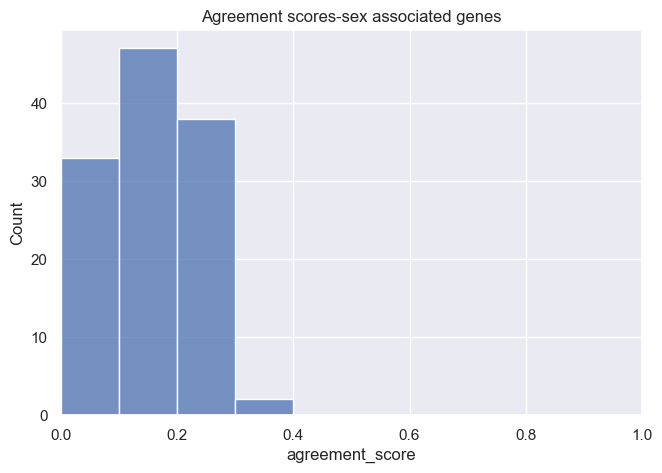

0.12000000000000002
0.10132456102380442


In [432]:
score = []

for idx in range(120):
    raw_data = set(sex_top_neighbors.iloc[:, idx])
    UMAP_data = set(sex_top_neighbors_UMAP.iloc[:, idx])
    score.append(len(raw_data.intersection(UMAP_data))/10)

score = pd.DataFrame(score)
score.index = top_neighbors.columns
score.columns = ["agreement_score"]

# print(np.mean(score.agreement_score))
# print(np.std(score.agreement_score))
sns.histplot(score.agreement_score, binwidth = 0.1)
plt.xlim((0,1))
plt.title("Agreement scores-sex associated genes")
plt.show()

print(np.mean(score.agreement_score))
print(np.std(score.agreement_score))

In [426]:
score

,agreement_score
07-08-095-0,0.0
07-08-120-8,0.2
07-08-122-0,0.1
07-08-123-1,0.1
07-08-015-6,0.1
...,...
07-08-160-0,0.2
07-08-163-7,0.1
07-08-085-2,0.2
07-08-082-3,0.1
